# Исследование данных развлекательного приложения

#### Описание проекта

Доступны данные развлекательного приложения Procrastinate Pro+ о пользователях, привлечённых с 1 мая по 27 октября 2019 года: посещения, покупки и рекламные расходы. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. 

**Цель исследования:** выявить причины убытков и помочь компании выйти в плюс.

**Задача** изучить:
* откуда приходят пользователи и какими устройствами они пользуются,
* сколько стоит привлечение пользователей из различных рекламных каналов;
* сколько денег приносит каждый клиент,
* когда расходы на привлечение клиента окупаются,
* какие факторы мешают привлечению клиентов.

#### Описание данных

Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, его структура:

* `User Id` — уникальный идентификатор пользователя,
* `Region` — страна пользователя,
* `Device` — тип устройства пользователя,
* `Channel` — идентификатор источника перехода,
* `Session Start` — дата и время начала сессии,
* `Session End` — дата и время окончания сессии.

Файл `orders_info_short.csv` — информацию о заказах, его структура:

* `User Id` — уникальный идентификатор пользователя,
* `Event Dt` — дата и время покупки,
* `Revenue` — сумма заказа.

Файл `costs_info_short.csv` — информацию о расходах на рекламу, его структура:

* `dt` — дата проведения рекламной кампании,
* `Channel` — идентификатор рекламного источника,
* `costs` — расходы на эту кампанию.

### Шаг 1. Загрузим данные и подготовим их к анализу

##### 1.1 Импортируем необходимые библиотеки и считаем CSV-файлы с данными, сохраним их в датафреймы

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

##### 1.2 Выведем первые строки набора данных. Изучим общую информацию датафреймах

In [3]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [7]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [9]:
#приведем названия столбцов к "змеиному" регистру
visits.columns = (visits.columns
                  .str.replace(' ', '_')
                  .str.lower())
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [10]:
#приведем названия столбцов к "змеиному" регистру
orders.columns = (orders.columns
                  .str.replace(' ', '_')
                  .str.lower())
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [11]:
#приведем названия столбцов к нижнему регистру
costs.columns = (costs.columns
                  .str.lower())
costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

In [12]:
#преобразуем данные о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [13]:
visits.dtypes

user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end              object
dtype: object

In [14]:
orders.dtypes

user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object

In [15]:
#посмотрим, какой временной промежуток охватывают данные
print('Период:', orders['event_dt'].dt.date.min(), '-', 
      orders['event_dt'].dt.date.max())
print('Период:', visits['session_start'].dt.date.min(), '-', 
      visits['session_start'].dt.date.max())
print('Период:', costs['dt'].min(), '-', 
      costs['dt'].max())

Период: 2019-05-01 - 2019-10-31
Период: 2019-05-01 - 2019-10-31
Период: 2019-05-01 - 2019-10-27


Проверим пропуски в данных

In [16]:
visits.isna().mean()*100

user_id          0.0
region           0.0
device           0.0
channel          0.0
session_start    0.0
session_end      0.0
dtype: float64

In [17]:
orders.isna().mean()*100

user_id     0.0
event_dt    0.0
revenue     0.0
dtype: float64

In [18]:
costs.isna().mean()*100

dt         0.0
channel    0.0
costs      0.0
dtype: float64

In [19]:
#проверим данные на наличие явных дубликатов
print(visits.duplicated().sum(), orders.duplicated().sum(), costs.duplicated().sum())

0 0 0


In [20]:
#проверим столбцы visits на наличие неявных дубликатов
print(visits['region'].sort_values().unique())
print(visits['device'].sort_values().unique())
print(visits['channel'].sort_values().unique())

['France' 'Germany' 'UK' 'United States']
['Android' 'Mac' 'PC' 'iPhone']
['AdNonSense' 'FaceBoom' 'LeapBob' 'MediaTornado' 'OppleCreativeMedia'
 'RocketSuperAds' 'TipTop' 'WahooNetBanner' 'YRabbit' 'lambdaMediaAds'
 'organic']


In [21]:
#проверим costs на наличие неявных дубликатов
costs['channel'].sort_values().unique()

array(['AdNonSense', 'FaceBoom', 'LeapBob', 'MediaTornado',
       'OppleCreativeMedia', 'RocketSuperAds', 'TipTop', 'WahooNetBanner',
       'YRabbit', 'lambdaMediaAds'], dtype=object)

##### Вывод
Загрузили и изучили данные о визитах, заказах и рекламных расходах. Обнаружили и исправили некорректный регистр в написании названий колонок. Столбцы с датой и временем привели к типу `datetime`. Убедились в отсутствии пропусков, явных и неявных дубликатов. Период соответствует указанному в описании данных: 2019-05-01 - 2019-10-31.

### Шаг 2. Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии

##### 2.1 Зададим функции для вычисления значений метрик

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

In [22]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [23]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [24]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [25]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

##### 2.2 Зададим функции для построения графиков

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [26]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [27]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [28]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [29]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Шаг 3. Проведем исследовательский анализ данных

##### 3.1 Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей

In [30]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [31]:
print('Минимальная дата привлечения:', profiles['dt'].min())
print('Максимальная дата привлечения:', profiles['dt'].max())

Минимальная дата привлечения: 2019-05-01
Максимальная дата привлечения: 2019-10-27


С помощью функции `get_profiles` составили профили с датой первого посещения, признаком оплаты и стоимостью привлечения каждого пользователя. Для дальнейшего анализа определили минимальную дату привлечения: 2019-05-01 и максимальную дату привлечения: 2019-10-27, они совпадают с датами, приведенными в описании.

##### 3.2 Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей

In [32]:
#напишем функцию для построения таблиц с группировкой пользователей по определнному признаку
def payer_table(index):
    pt = profiles.pivot_table(index=index,
                              values='payer',
                              aggfunc=['count', 'sum', 'mean'])
    pt.columns = ['users_total', 'users_payer', 'payer_rate, %']
    pt['payer_rate, %'] = round((pt['payer_rate, %'] * 100), 1)
    return pt.sort_values(by='payer_rate, %', ascending=False)

In [33]:
#построим таблицу, отражающую количество пользователей, количество платящих пользователей и долю платящих
#по каждой стране
payer_table('region')

,users_total,users_payer,"payer_rate, %"
region,,,
United States,100002,6902,6.9
Germany,14981,616,4.1
UK,17575,700,4.0
France,17450,663,3.8


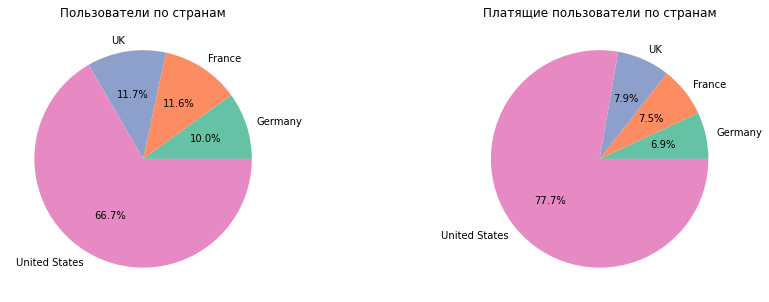

In [34]:
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
payer_table('region')['users_total'].sort_values().plot(kind='pie', autopct='%1.1f%%',
                                          colors=sns.color_palette('Set2'), ax=ax1)
plt.rc('font', size=10)
plt.title('Пользователи по странам')
plt.ylabel('')

ax2 = plt.subplot(1, 2, 2)
payer_table('region')['users_payer'].sort_values().plot(kind='pie', autopct='%1.1f%%',
                                          colors=sns.color_palette('Set2'), ax=ax2)
plt.rc('font', size=10)
plt.title('Платящие пользователи по странам')
plt.ylabel('')

plt.show()

Наибольшее количество платящих пользователей приходится на США: среди всех установивших приложение 6.9% приносят доход. Для Германии, Великобритании и Франции доля платящих пользователей примерно одинакова - около 4%. Также по таблице и диаграмме можно увидеть, что количество пользоватей из США в 6-7 раз превышает количество пользователей в других странах, а платящие пользователи США занимают почти 80% всех приносящих доход клиентов.

##### 3.3 Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи
Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства

In [35]:
#построим таблицу, отражающую количество пользователей, количество платящих пользователей и долю платящих
#по каждому девайсу
payer_table('device')

,users_total,users_payer,"payer_rate, %"
device,,,
Mac,30042,1912,6.4
iPhone,54479,3382,6.2
Android,35032,2050,5.9
PC,30455,1537,5.0


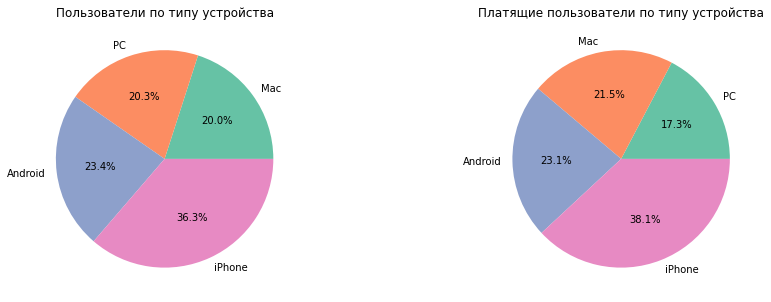

In [36]:
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
payer_table('device')['users_total'].sort_values().plot(kind='pie', autopct='%1.1f%%',
                                          colors=sns.color_palette('Set2'), ax=ax1)
plt.rc('font', size=10)
plt.title('Пользователи по типу устройства')
plt.ylabel('')

ax2 = plt.subplot(1, 2, 2)
payer_table('device')['users_payer'].sort_values().plot(kind='pie', autopct='%1.1f%%',
                                          colors=sns.color_palette('Set2'), ax=ax2)
plt.rc('font', size=10)
plt.title('Платящие пользователи по типу устройства')
plt.ylabel('')

plt.show()

Как можно заметить по графикам, в целом наибольшее количество пользователей и платящих составляют владельцы iPhone: 36% и 38% соответственно. При этом соотношение платящих пользователей к неплатящим составляет 6.2%, а самое высокое значение этого показателя среди пользователей Mac - 6.4%, для Android - 5.9% и менее всего переходят в покупки пользователи PC - 5%.

##### 3.4 Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей

In [37]:
#построим таблицу, отражающую количество пользователей, количество платящих пользователей и долю платящих
#по каждому каналу
payer_table('channel')

,users_total,users_payer,"payer_rate, %"
channel,,,
FaceBoom,29144,3557,12.2
AdNonSense,3880,440,11.3
lambdaMediaAds,2149,225,10.5
TipTop,19561,1878,9.6
RocketSuperAds,4448,352,7.9
WahooNetBanner,8553,453,5.3
YRabbit,4312,165,3.8
MediaTornado,4364,156,3.6
LeapBob,8553,262,3.1


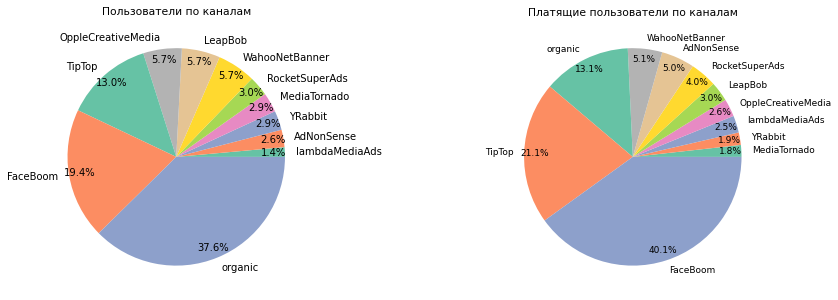

In [38]:
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
payer_table('channel')['users_total'].sort_values().plot(kind='pie', autopct='%1.1f%%',
                                          colors=sns.color_palette('Set2'),
                                          pctdistance=0.9)
plt.rc('font', size=9)
plt.title('Пользователи по каналам')
plt.ylabel('')

ax1 = plt.subplot(1, 2, 2)
payer_table('channel')['users_payer'].sort_values().plot(kind='pie', autopct='%1.1f%%',
                                          colors=sns.color_palette('Set2'),
                                          pctdistance=0.9)
plt.rc('font', size=9)
plt.title('Платящие пользователи по каналам')
plt.ylabel('')

plt.show()

Органические пользователи лидируют и составляют 37.6% от общего числа пользователей приложения. Также в числе лидеров по привлечению каналы FaceBoom (19.4%), TipTop (13%), OppleCreativeMedia, LeapBob, WahooNetBanner (по 5.7%). На остальные каналы приходится менее 13% пользователей в совокупности.

Среди платящих пользователей можно выделить каналы FaceBoom с долей 40.1%, TipTop (21.1%), Organic (13.1%), WahooNetBanner (5.1%), AdNonSense (5%), RocketSuperAds (4%), доля остальных каналов среди платящих пользователей около 12%. 

12.2% пользователей, пришедших из канала FaceBoom совершают покупки в приложении, также по этому показателю лидируют AdNonSense (11.3%), lambdaMediaAds (10.5%), TipTop (9.6%), RocketSuperAds (7.9%) и WahooNetBanner (5.3%). Из остальных каналов покупателями становятся менее 4% пользователей. Органические пользователи хоть и являются самой многочисленной группой, всего 2.1% из них становятся платящими пользователями.

##### Вывод
Платящие пользователи США занимают почти 80% всех приносящих доход клиентов. Самая высокая доля платящих пользователей тоже в США: среди всех установивших приложение 6.9% приносят доход. В Германии, Великобритании и Франции - около 4%.

Самая многочисленная группа в разрезе устройств - владельцы iPhone: 36% среди общего числа пользователей и 38% среди платящих. При этом соотношение платящих пользователей к неплатящим составляет 6.2%, а самое высокое значение этого показателя среди пользователей Mac - 6.4%, для Android - 5.9% и менее всего переходят в покупки пользователи PC - 5%.

Больше всего пользователей пришли в приложение органически - 37.6%. Также популярны каналы FaceBoom (19.4%), TipTop (13%), OppleCreativeMedia, LeapBob, WahooNetBanner (по 5.7%). Среди платящих пользователей по количеству пользователей лидируют FaceBoom с долей 40.1%, TipTop (21.1%), Organic (13.1%), WahooNetBanner (5.1%), AdNonSense (5%), RocketSuperAds (4%), на остальные каналы приходится всего 12% в совокупности. 

12.2% пользователей, пришедших из канала FaceBoom совершают покупки в приложении, также по этому показателю лидируют AdNonSense (11.3%), lambdaMediaAds (10.5%), TipTop (9.6%), RocketSuperAds (7.9%) и WahooNetBanner (5.3%). 

### Шаг 4. Маркетинг

##### 4.1 Посчитаем общую сумму расходов на маркетинг

In [39]:
print('Общая сумма расходов на маркетинг:', round(profiles['acquisition_cost'].sum()))

Общая сумма расходов на маркетинг: 105497


##### 4.2 Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник

In [40]:
channel_cost = (profiles
                .groupby('channel')
                .agg({'acquisition_cost': 'sum'})
                .sort_values(by='acquisition_cost', ascending=False))
channel_cost['channel_ratio, %'] = round((channel_cost['acquisition_cost'] / channel_cost['acquisition_cost'].sum() * 100), 1)
channel_cost

,acquisition_cost,"channel_ratio, %"
channel,,
TipTop,54751.30,51.9
FaceBoom,32445.60,30.8
WahooNetBanner,5151.00,4.9
AdNonSense,3911.25,3.7
OppleCreativeMedia,2151.25,2.0
RocketSuperAds,1833.00,1.7
LeapBob,1797.60,1.7
lambdaMediaAds,1557.60,1.5
MediaTornado,954.48,0.9


Самыми дорогими рекламными источниками за рассматриваемый период являются каналы TipTop и FaceBoom, расходы на них более чем в 10 раз превышают расходы на другие каналы. Траты на канал TipTop превышают половину общих расходов на маркетинг. Органические пользователи, как и ожидалось, привлечены в приложение бесплатно, что подтверждает. корректность анализируемых данных.

##### 4.3 Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируем динамику изменения расходов во времени по месяцам по каждому источнику

In [41]:
#добавим столбец с неделями для построения графиков
profiles['week'] = profiles['first_ts'].dt.isocalendar().week

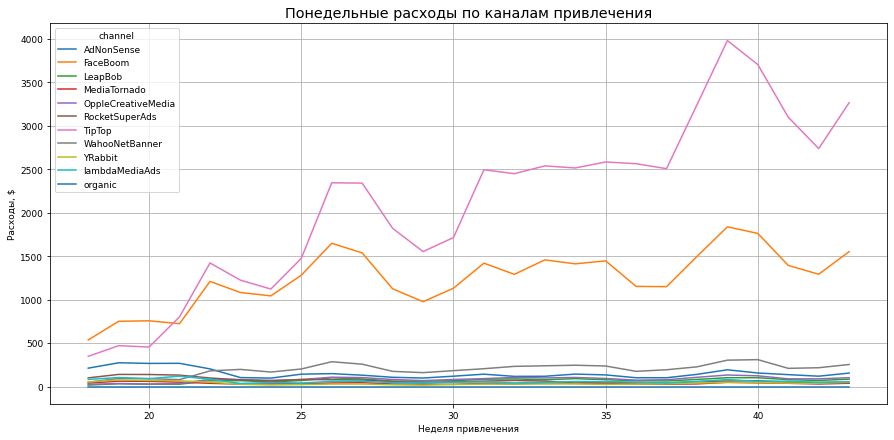

In [42]:
# построим понедельный график изменения расходов по каналам привлечения
profiles.pivot_table(
    index='week', columns='channel', values='acquisition_cost', aggfunc='sum'
).plot(grid=True, figsize=(15, 7))
plt.rc('font', size=12)
plt.ylabel('Расходы, $')
plt.xlabel('Неделя привлечения')
plt.title('Понедельные расходы по каналам привлечения')
plt.show()

Как мы уже выяснили, два самых дорогих канала - TipTop и FaceBoom - расходы на них начинают активно отрываться от других с 21 недели. При этом до 25 недели на лидирующие каналы компания тратит примерно одинаково, а после траты на TipTop растут активнее. По обоим каналам наблюдаем пики на 26 и 39 неделях.

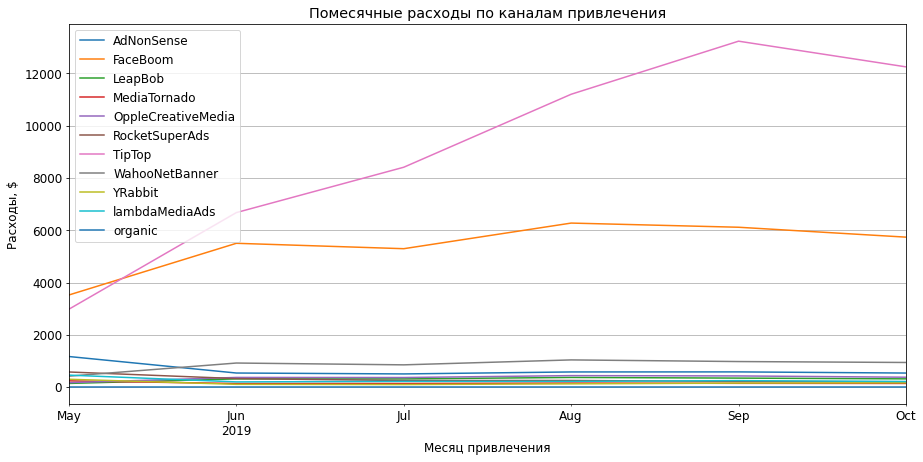

In [43]:
# построим помесячный график изменения расходов по каналам привлечения
profiles.pivot_table(
    index='month', columns='channel', values='acquisition_cost', aggfunc='sum'
).plot(grid=True, figsize=(15, 7))
plt.rc('font', size=12)
plt.ylabel('Расходы, $')
plt.xlabel('Месяц привлечения')
plt.title('Помесячные расходы по каналам привлечения')
plt.legend(loc='upper left')
plt.show()

В помесячном распределении расходов по каналам рост расходов TipTop становится более явным: c \\$3000  в мае траты на канал стремительно росли и достигли \\$13000 в сентябре, только в октябре видим спад до \\$12000.

Рост расходов на FaceBoom хоть и стартовал вместе с TipTop, в июне-июле стабилизируется на отметке около \\$5000, августе-октябре - \\$6000.

##### 4.4 Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника

In [44]:
(profiles
 .groupby('channel').agg({'acquisition_cost': 'mean'})
 .sort_values(by='acquisition_cost', ascending=False))

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


In [45]:
print('Средняя стоимость привлечения по всем пользователям:', profiles['acquisition_cost'].mean())

Средняя стоимость привлечения по всем пользователям: 0.7032778251826568


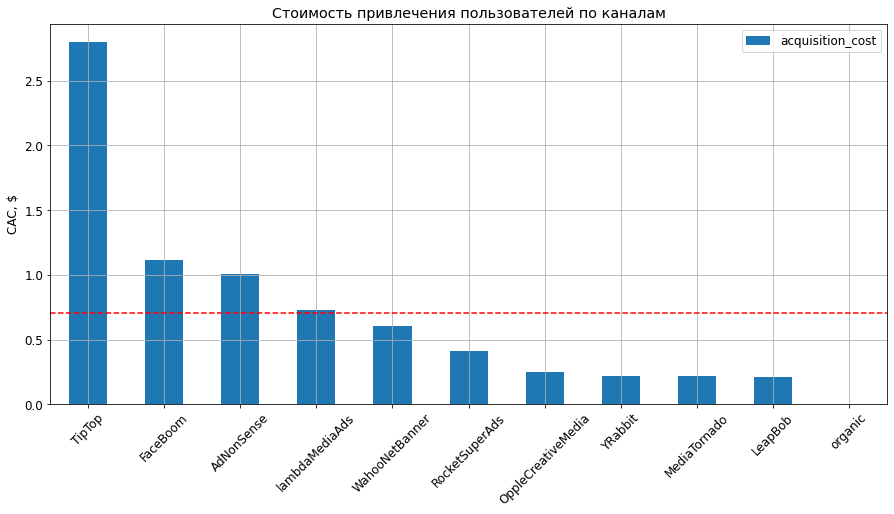

In [46]:
(profiles
 .groupby('channel').agg({'acquisition_cost': 'mean'})
 .sort_values(by='acquisition_cost', ascending=False)
 .plot(kind='bar', grid=True, figsize=(15, 7)))
plt.axhline(y=profiles['acquisition_cost'].mean(), color='red', linestyle='--', label='Средний САС')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('CAC, $')
plt.title('Стоимость привлечения пользователей по каналам')
plt.show()


Самые дорогие пользователи приходят из канала TipTop, средняя стоимость привлечения каждого из них более \\$2.5 при средней стоимости привлечения \\$0.7. Также превышают среднюю стоимость пользователи из FaceBoom (\\$1.1) и AdNonSense (\\$1).

##### Вывод

С мая по октябрь компания потратила на маркетинг \\$105497. 

Большая часть этой суммы приходится на следующие каналы:

| Канал                | Доля в общих затратах | Расходы        | CAC |
|----------------------|-----------------------|----------------|-------------|
| TipTop               | 51.9%                 | \\$54751       | \\$2.8      |
| FaceBoom             | 30.8%                 | \\$32446       | \\$1.1      |



Средняя стоимость привлечения пользователей - \\$0.7, пользователи из TipTop в 4 раза дороже, из FaceBoom - почти в 2 раза. Также превышают среднюю стоимость пользователи, пришедшие через AdNonSense (\\$1).

Расходы на TipTop с мая по сентябрь 2019г. выросли более чем в 4 раза: c \\$3000 до \\$13000, только в октябре видим спад до \\$12000.

Рост расходов на FaceBoom хоть и стартовал вместе с TipTop, в июне-июле стабилизируется на отметке около \\$5000-6000 в месяц.


### Шаг 5. Оценим окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. 

* Дата исследования: 1 ноября 2019 года
* Рассчитанный период анализируемых данных: 1 мая 2019 - 27 октября 2019 года
* Плановый период окупаемости привлеченных пользователей: <= 14 дней после привлечения. 

Поскольку на этом шаге мы будем оценивать окупаемость рекламы, исключим из анализа пользователей `organic`, т.е. привлеченных бесплатно.

##### 5.1 Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI

In [47]:
#зададим момент и горизонт анализа

observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

In [48]:
profiles = profiles.query('channel != "organic"')

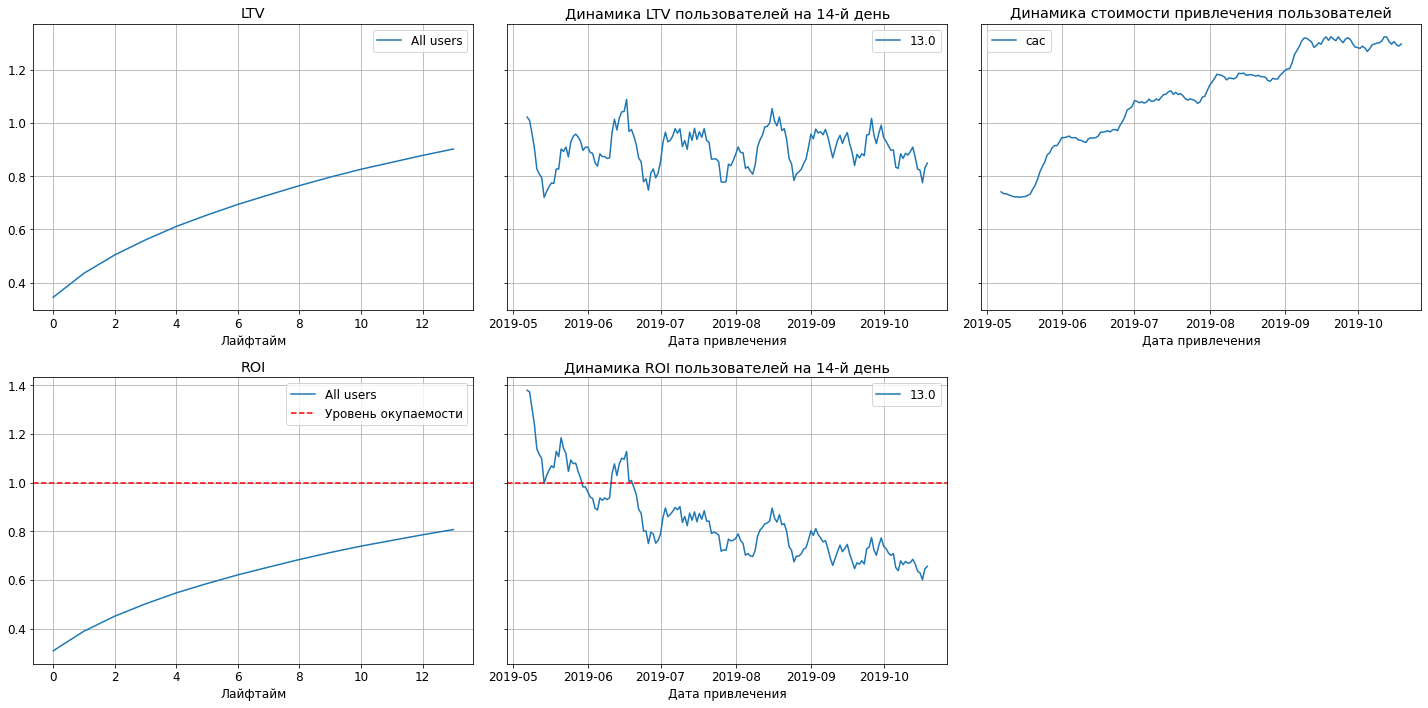

In [49]:
#рассчитаем LTV и ROI, вызвав функцию get_ltv()

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days)

#построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

LTV стабильно растет, то есть пользователи продолжают совершать покупки в приложении. По графику ROI видим, что к концу 2-й недели его уровень около 80%, значит, реклама не окупается. Скорее всего, это связано с ростом рекламных расходов: CAC от \\$0.7 в мае возрос до \\$1.3 в ноябре. Самым дорогим каналом привлечения оказался TipTop, вероятно, исключив его, можно стабилизировать расходы и повысить уровень окупаемости, проверим это на графиках.

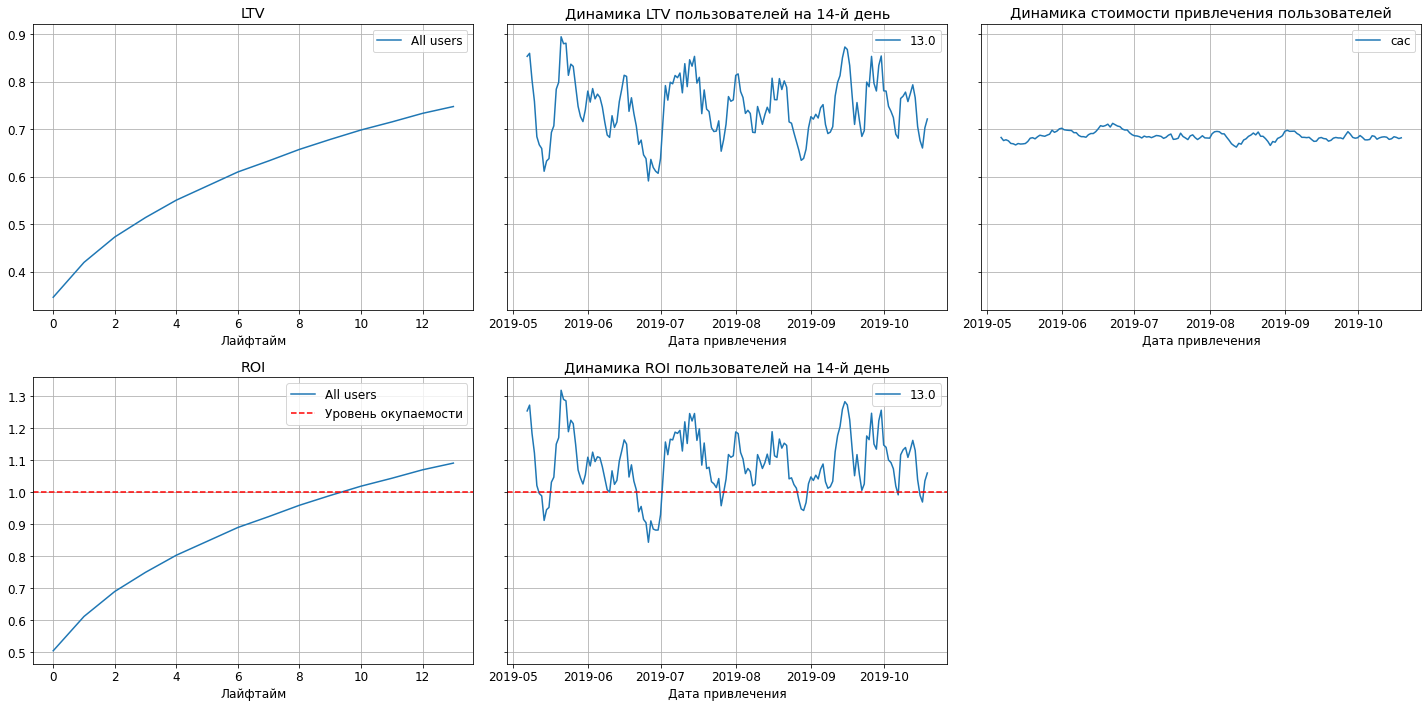

In [50]:
profiles_test = profiles.query('channel != "TipTop"')

#рассчитаем LTV и ROI, вызвав функцию get_ltv()

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_test, orders, observation_date, horizon_days)

#построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Действительно, без TipTop стоимость привлечения пользователей колеблется на уровне \\$0.7 на протяжении всего анализируемого периода, реклама начинает окупаться к середине второй недели, ROI в динамике хоть и нестабилен, но чаще выше уровня окупаемости.

##### 5.2 Проверим конверсию и удержание пользователей, а также динамику их изменения
Построим и изучим графики конверсии и удержания

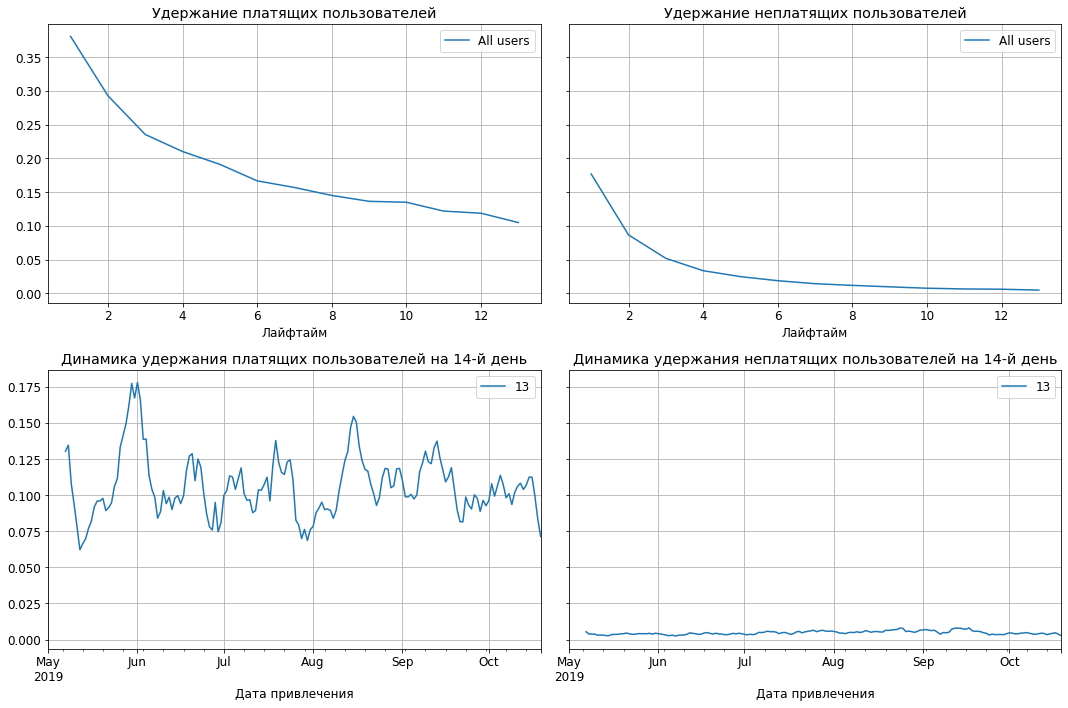

In [51]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание убывает по экспоненциальному закону, удержание неплатящих убывает быстрее, чем платящих. Самые высокие показатели удержания на 14-й день для платящих пользователей, привлеченных в июне, видим спад в июле и резкий скачок в августе, после чего график становится более стабильным и снова стремится вниз в середине октября.

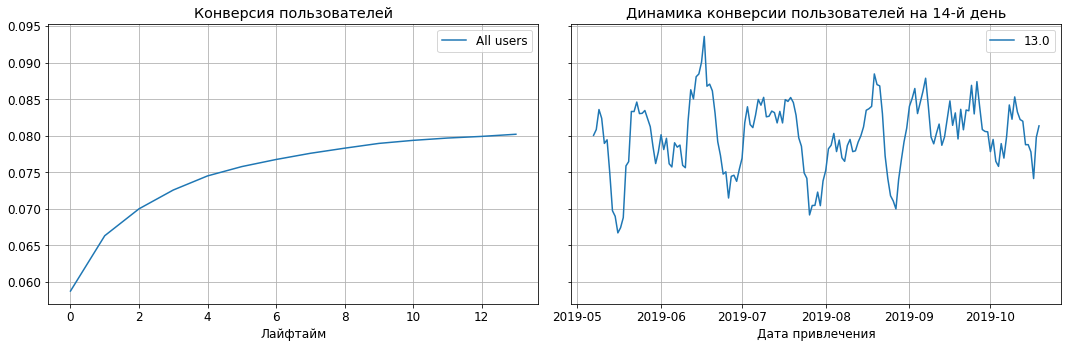

In [52]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия пользователей активно растет с 0 до 2 лайфтайма, далее график принимает более плавный вид.

##### 5.3 Проанализируем окупаемость рекламы с разбивкой по устройствам

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI

In [53]:
dimensions = ['device']

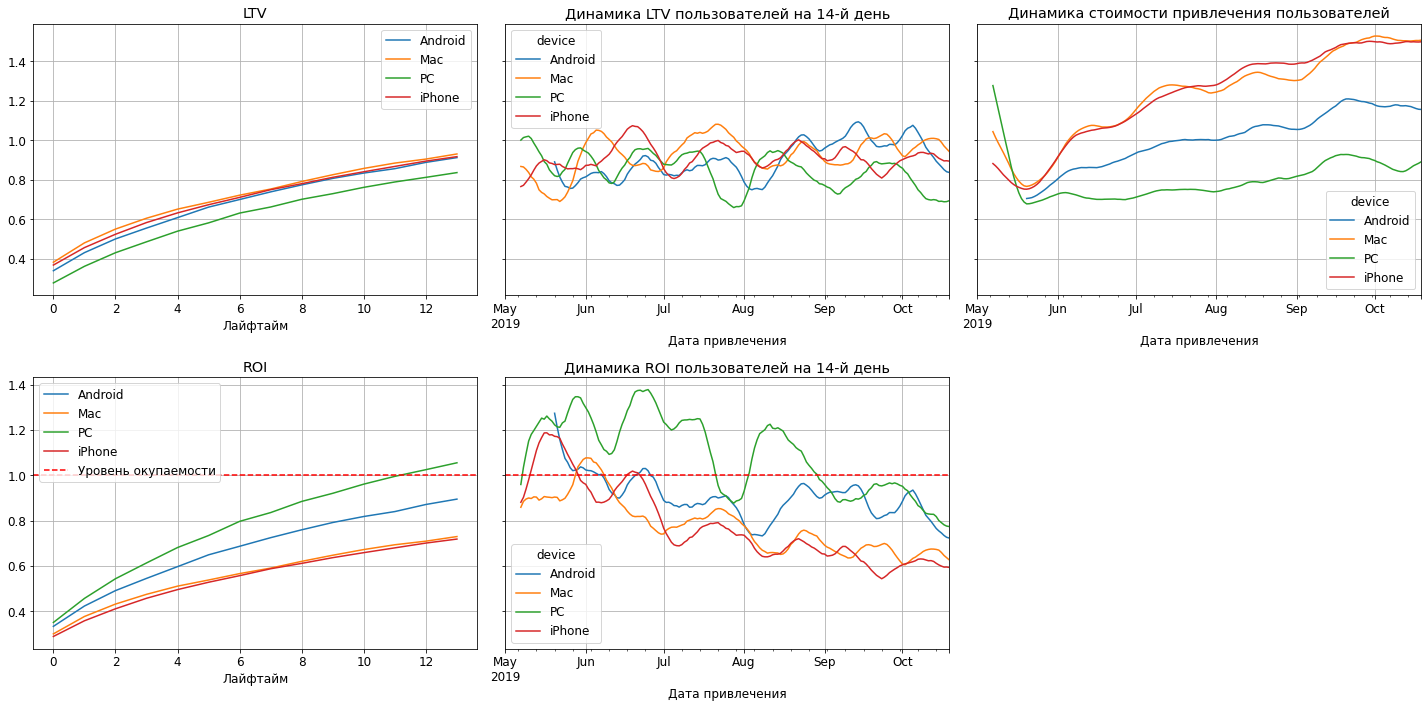

In [54]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

#сгладим графики динамики ltv, roi и построим диаграммы
ltv_history_filtered = filter_data(ltv_history, 14)
roi_history_filtered = filter_data(roi_history, 14)
plot_ltv_roi(ltv_grouped, ltv_history_filtered, roi_grouped, roi_history_filtered, horizon_days) 

По всем устройствам видим похожую картину: 
- стабильное качество привлечения пользователей, 
- снижение стоимости привлечения в мае и рост, начиная с июня
- приближение к уровню окупаемости по всем когортам,
- снижение ROI в динамике от 120% до 60% c одновременным ростом расходов на рекламу в аналогичные периоды.

Среди всех когорт выделяются пользователи PC: несмотря на то, что LTV у них стабильно ниже других, траты на маркетинг относительно невысоки и находятся на уровне \\$0.7-\\$0.9. Пользователи PC - единственная когорта, превысившая уровень окупаемости в течение 2-х недель, однако в динамике ROI имеет тенденцию к снижению. Похоже себя ведут пользователи Android, у пользователей iPhone и Mac выше LTV, но стоимость удержания выше на \\$0.2-\\$0.6, соответственно ниже ROI.

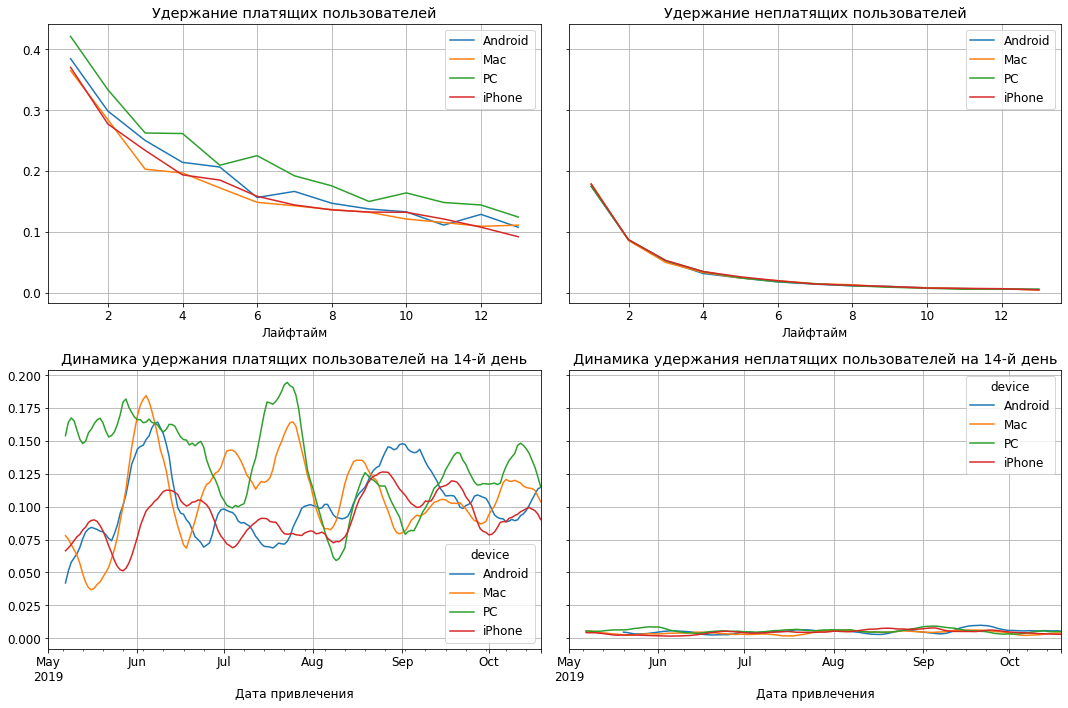

In [55]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

#сгладим графики динамики удержания и построим диаграммы
retention_history_filtered = filter_data(retention_history, 14)
plot_retention(retention_grouped, retention_history_filtered, horizon_days)

Лучше всего удерживаются пользователи PC. По скачкам в июне и июле можно предположить, что маркетологи стимулировали удержание в эти периоды.

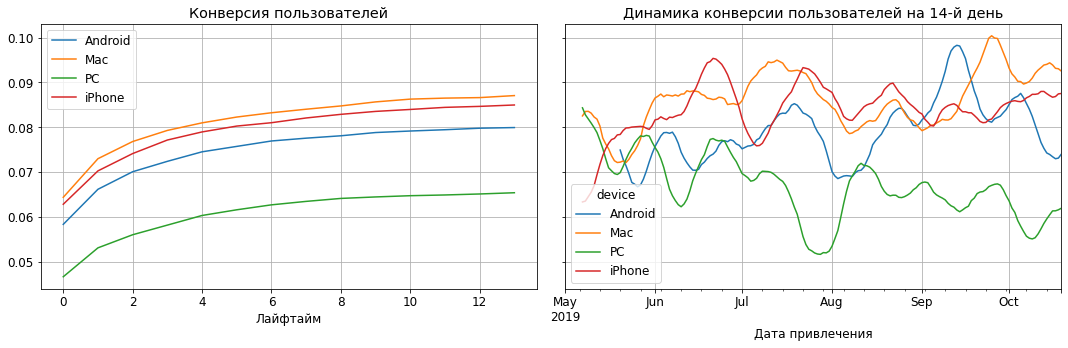

In [56]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

#сгладим графики динамики конверсии и построим диаграммы
conversion_history_filtered = filter_data(conversion_history, 14)
plot_conversion(conversion_grouped, conversion_history_filtered, horizon_days)

По конверсии все наоборот: чаще всего целевые действия совершают пользователи iPhone и Mac, хуже всего конвертируются пользователи PC.

##### 5.4 Проанализируем окупаемость рекламы с разбивкой по странам

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI

In [57]:
dimensions = ['region']

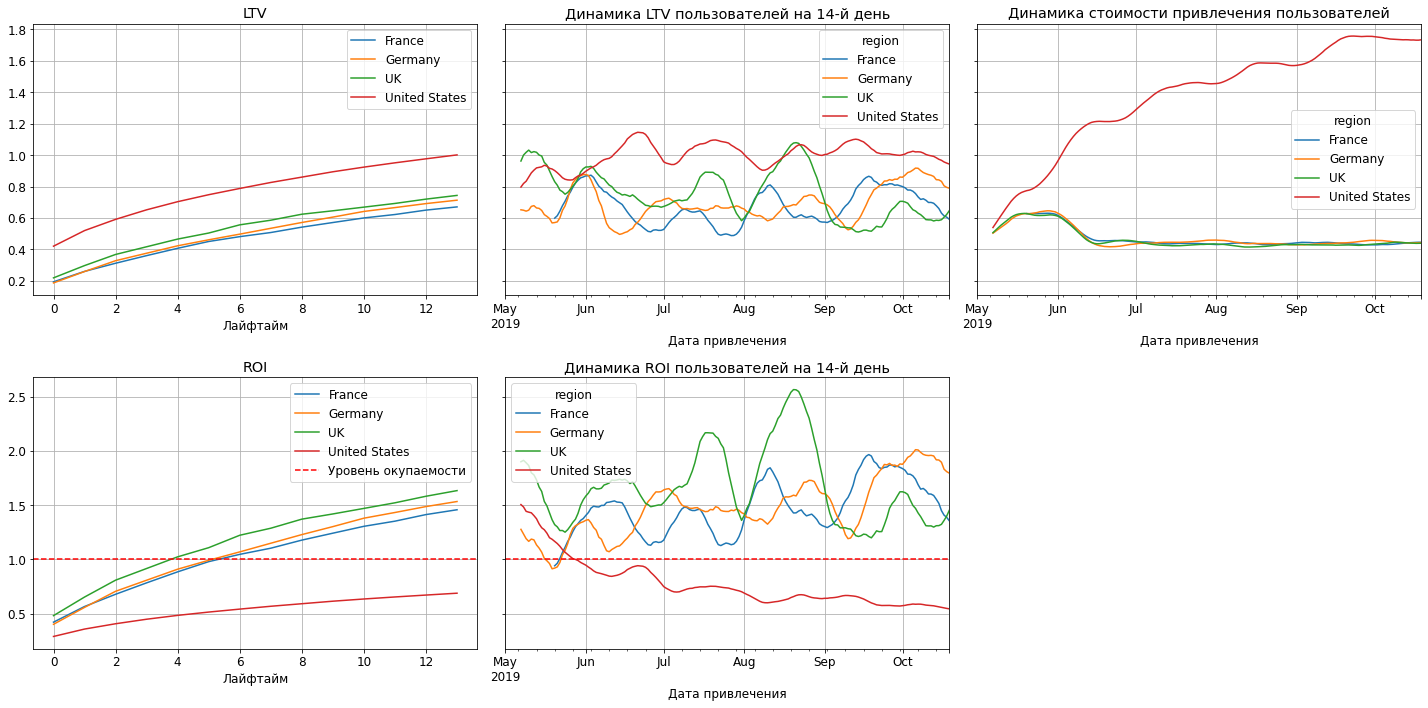

In [58]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

#сгладим графики динамики ltv, roi и построим диаграммы
ltv_history_filtered = filter_data(ltv_history, 14)
roi_history_filtered = filter_data(roi_history, 14)
plot_ltv_roi(ltv_grouped, ltv_history_filtered, roi_grouped, roi_history_filtered, horizon_days) 

Больше всего выручки приложение получает от пользователей из США, однако это единственная страна, затраты на привлечение пользователей которой окупаются очень медленно и всего на 70%, тогда как затраты на маркетинг по остальным странам начинают окупаться уже на первой неделе жизни пользователей. Это связано с тем, что CAC по США постоянно и очень быстро растет: от \\$0.6 в мае затраты достигают отметки \\$1.7 в октябре.

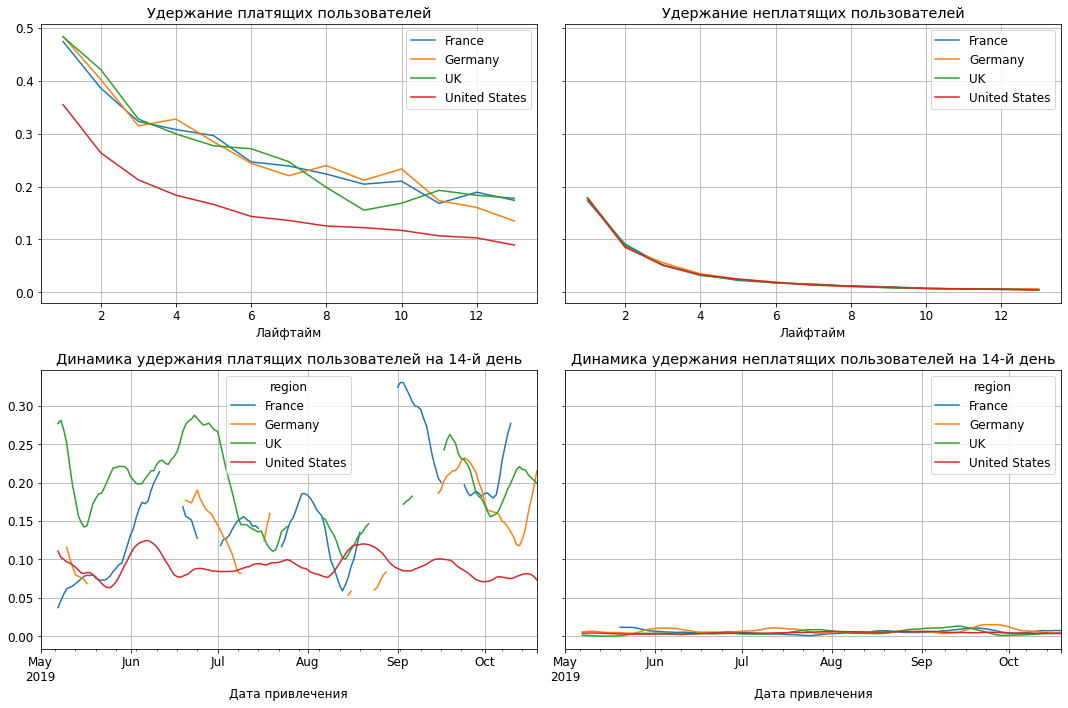

In [59]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

#сгладим графики динамики удержания и построим диаграммы
retention_history_filtered = filter_data(retention_history, 14)
plot_retention(retention_grouped, retention_history, horizon_days)

На графиках видим возможную причину неестественно высоких затрат на рекламу для пользователей из США - удержание платящих пользователей гораздо ниже, чем у других когорт, и находится на уровне 10%, тогда как для других стран этот показатель находится в среднем на уровне 15%. Вероятно, компания пыталась улучшить этот показатель повышением затрат на рекламу. Но можно заметить, что эта когорта самая стабильная, пользователи из Германии, Франции и Великобритании не всегда "доживали" до 14-го дня. 

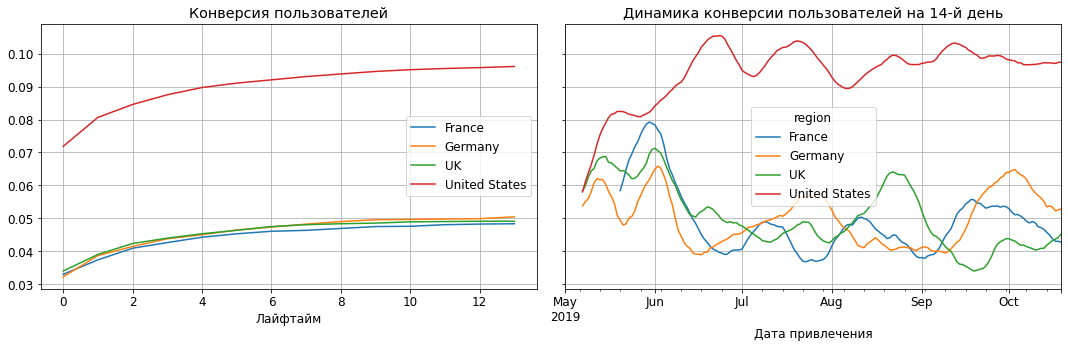

In [60]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

#сгладим графики динамики конверсии и построим диаграммы
conversion_history_filtered = filter_data(conversion_history, 14)
plot_conversion(conversion_grouped, conversion_history_filtered, horizon_days)

Пользователи из США чаще других совершают целевые действия, их показатель конверсии с 6% в мае повышается до уровня 10% в июне, тогда как пользователи из других стран совершают покупку в июне, а далее показатель конверсии колеблется на уровне 4-5%.

##### 5.5 Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI

In [61]:
dimensions = ['channel']

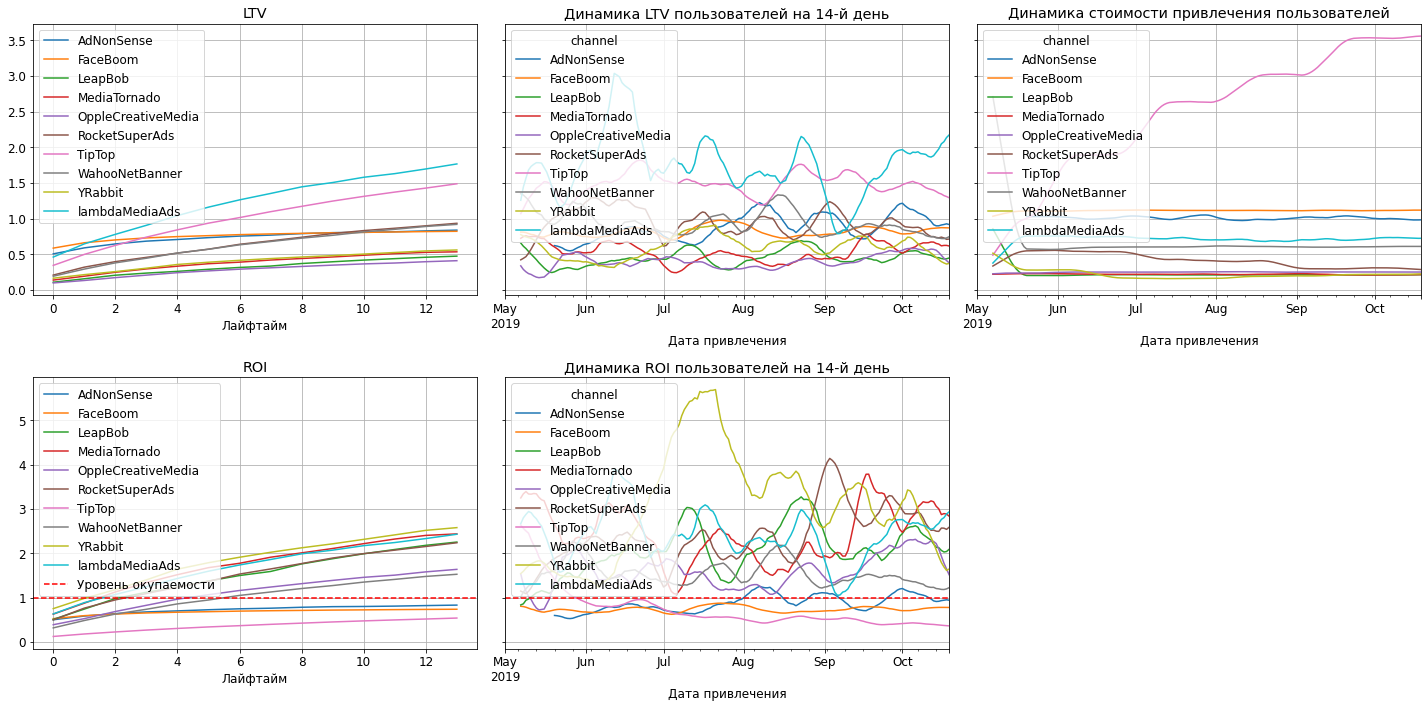

In [62]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

#сгладим графики динамики ltv, roi и построим диаграммы
ltv_history_filtered = filter_data(ltv_history, 14)
roi_history_filtered = filter_data(roi_history, 14)
plot_ltv_roi(ltv_grouped, ltv_history_filtered, roi_grouped, roi_history_filtered, horizon_days) 

Реклама окупается к концу первой недели по всем каналам, кроме AdNonSense, FaceBoom и TipTop. По этим же каналам самые высокие затраты на маркетинг. У большинства рекламных источников CAC на уровне \\$0.3-\\$0.4, у AdNonSense во все месяцы около \\$1, у FaceBoom стабильно около \\$1.2, TipTop снова бьет рекорды по неэффективности рекламы: затраты от \\$0.5 в мае выросли до \\$3.6 в октябре. При этом качество привлеченных пользователей по TipTop хорошее. 

Самый стабильный по всем показателям канал - lambdaMediaAds - пользователи, пришедшие оттуда, приносят наибольший доход, судя по графикам LTV. Лучший по показателям окупаемости - YRabbit за счет скачков ROI в июле и августе и стабильно низким CAC (\\$0.2)

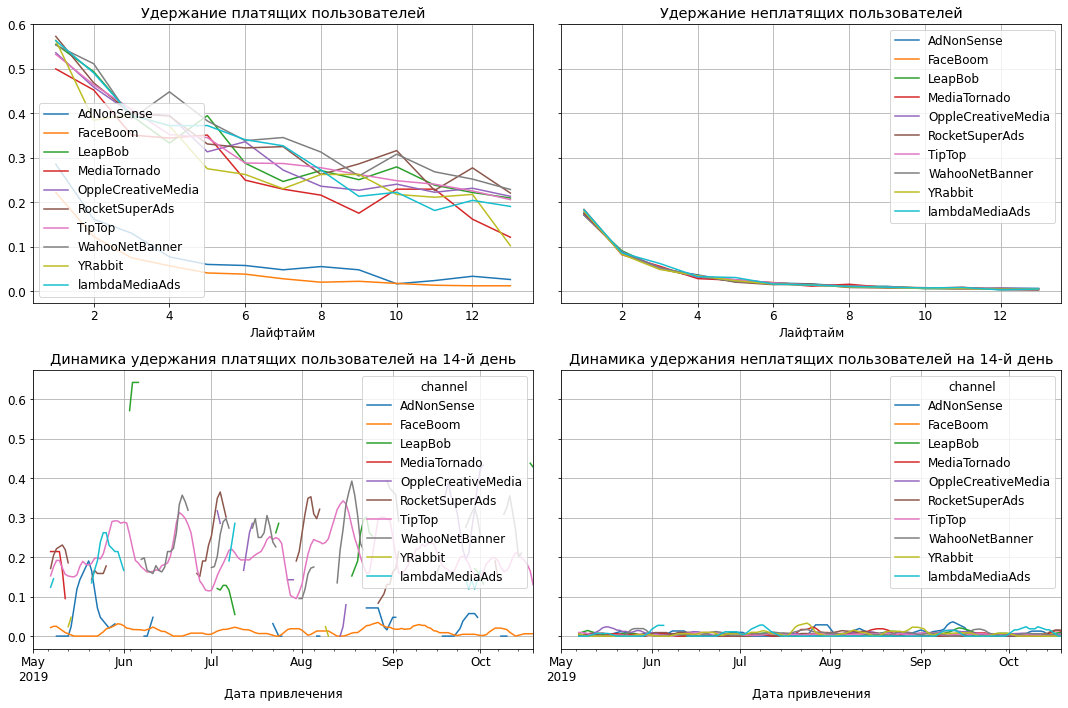

In [63]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=dimensions)

#сгладим графики динамики удержания и построим диаграммы
retention_history_filtered = filter_data(retention_history, 3)
plot_retention(retention_grouped, retention_history_filtered, horizon_days)

Пользователи из большинства каналов не доживают до 14-го дня, при этом процент удержания достаточно высокий - около 20%, самый стабильный среди них TipTop. Хуже всего удерживаются платные пользователи, пришедшие из FaceBoom, AdNonSense. По неплатящим пользователям удержание стабильно низкое и не превышает 5%.

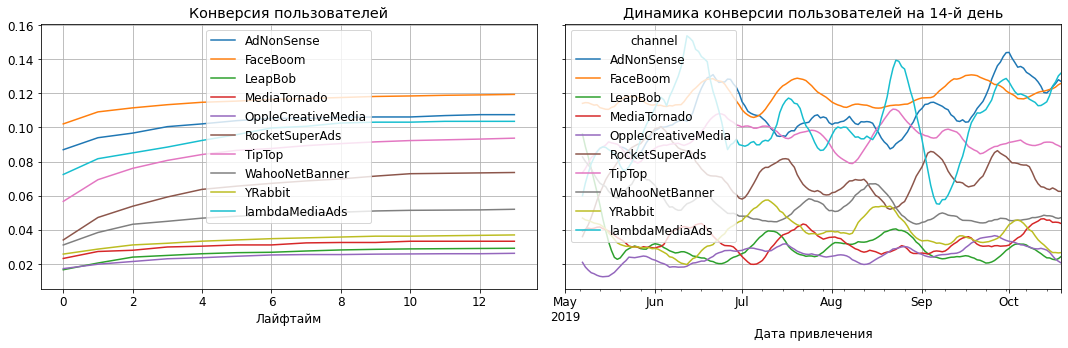

In [64]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)
#сгладим и построим график динамики конверсии
conversion_history_filtered = filter_data(conversion_history, 14)
plot_conversion(conversion_grouped, conversion_history_filtered, horizon_days)

Лучше всего конвертируются пользователи из FaceBoom (12%), AdNonSense (11%), lambdaMediaAds (10%) и TipTop (9%). Самые нестабильные пользователи приходят из lambdaMediaAds, они хорошо переходят в покупки в июне и середине августа, а в конце августа-начале сентября их конверсия резко падает с 14% до 6%, к октябрю показатель снова растет и достигает отметки в 13%.

##### 5.6 Проанализируем окупаемость каналов по странам

Поскольку мы выявили, что реклама не окупается в США и по крупнейшим каналам AdNonSense, FaceBoom и TipTop, посмотрим разбивку по регионам и каналам более подробно.

In [65]:
us_profiles = profiles.query('region == "United States"')

In [66]:
pt = us_profiles.pivot_table(index='channel',
                          values='payer',
                          aggfunc=['count', 'sum', 'mean'])
pt.columns = ['users_total', 'users_payer', 'payer_rate, %']
pt['payer_rate, %'] = round((pt['payer_rate, %'] * 100), 1)
pt.sort_values(by='payer_rate, %', ascending=False)

,users_total,users_payer,"payer_rate, %"
channel,,,
FaceBoom,29144,3557,12.2
TipTop,19561,1878,9.6
RocketSuperAds,4448,352,7.9
YRabbit,4312,165,3.8
MediaTornado,4364,156,3.6


In [67]:
dimensions = ['channel']

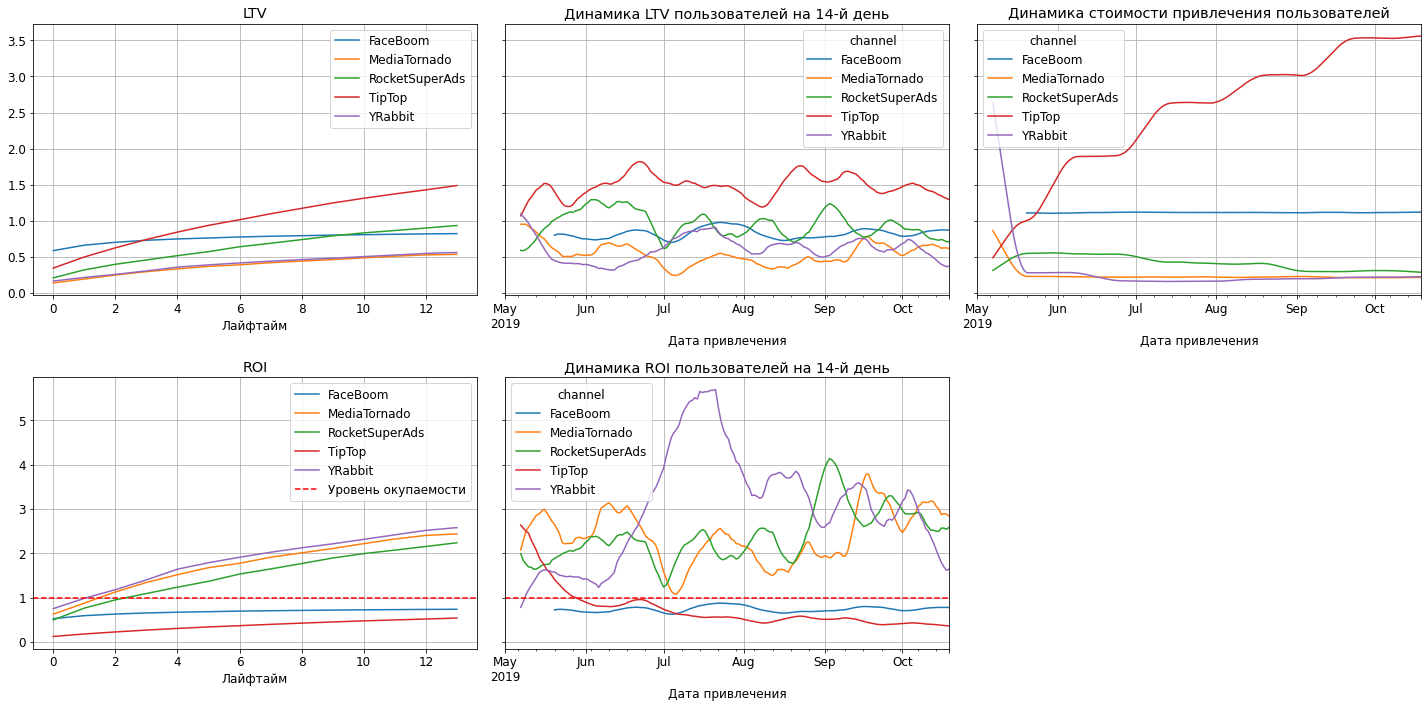

In [68]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    us_profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

#сгладим графики динамики ltv, roi и построим диаграммы
ltv_history_filtered = filter_data(ltv_history, 14)
roi_history_filtered = filter_data(roi_history, 14)
plot_ltv_roi(ltv_grouped, ltv_history_filtered, roi_grouped, roi_history_filtered, horizon_days) 

Реклама в США не окупается по каналам TipTop и FaceBoom, по ним же самые высокие траты на привлечение пользователей. У FaceBoom CAC стабильно на уровне \\$1.2, по TipTop видим знакомую траекторию ежемесячного роста затрат. Положительную динамику ROI показывают каналы RocketSuperAds и MediaTornado, при этом 8% пользователей, пришедших из RocketSuperAds, становятся покупателями.

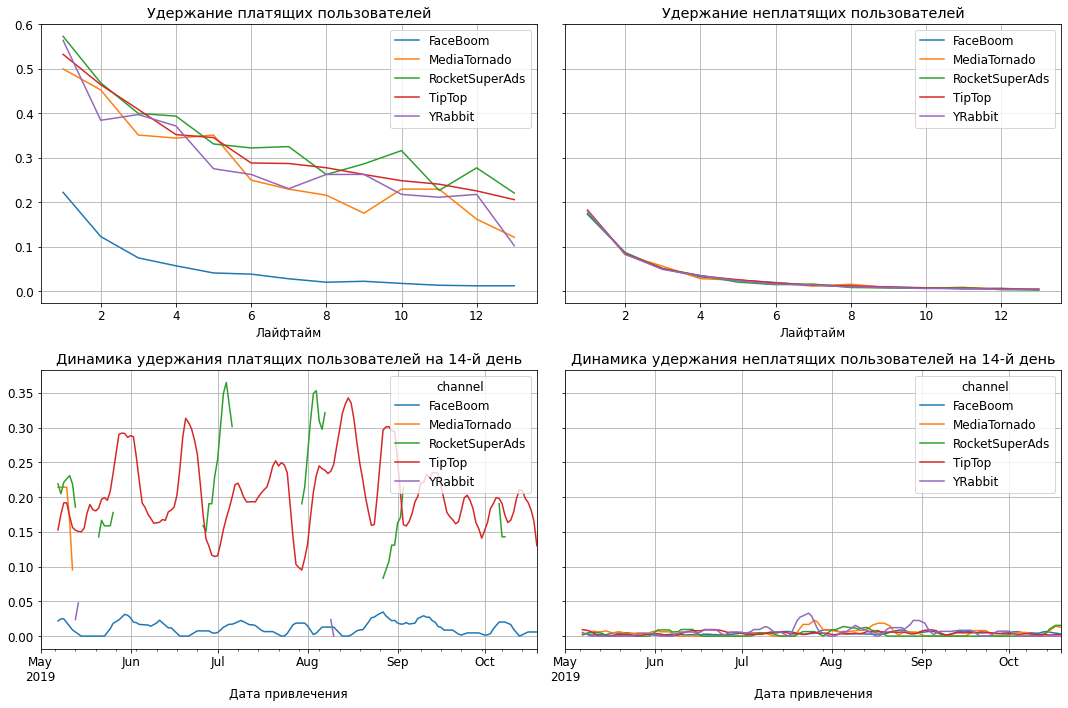

In [69]:
retention_raw, retention_grouped, retention_history = get_retention(
    us_profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=dimensions)

#сгладим графики динамики удержания и построим диаграммы
retention_history_filtered = filter_data(retention_history, 3)
plot_retention(retention_grouped, retention_history_filtered, horizon_days)

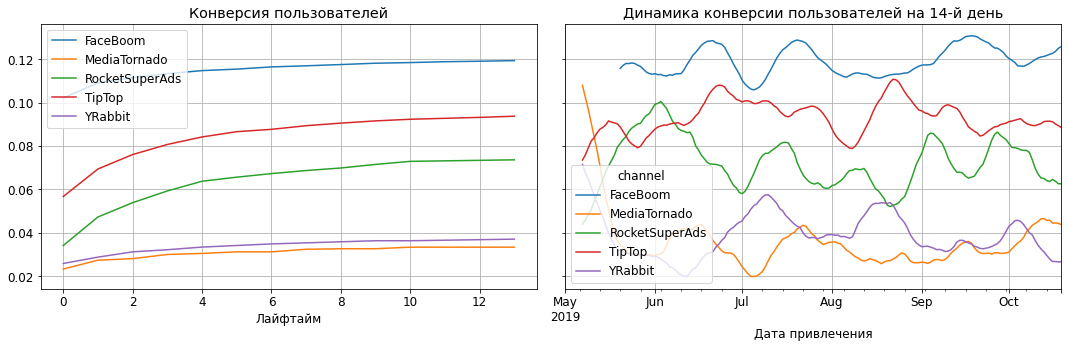

In [70]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    us_profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)
#сгладим и построим график динамики конверсии
conversion_history_filtered = filter_data(conversion_history, 14)
plot_conversion(conversion_grouped, conversion_history_filtered, horizon_days)

FaceBoom выделяется низкими показателями удержания (менее 5%) и высокой конверсией (12%). По TipTop эти показатели близки к значениям по другим рекламным каналам.

In [71]:
eu_profiles = profiles.query('region != "United States"')

In [72]:
pt = eu_profiles.pivot_table(index='channel',
                          values='payer',
                          aggfunc=['count', 'sum', 'mean'])
pt.columns = ['users_total', 'users_payer', 'payer_rate, %']
pt['payer_rate, %'] = round((pt['payer_rate, %'] * 100), 1)
pt.sort_values(by='payer_rate, %', ascending=False)

,users_total,users_payer,"payer_rate, %"
channel,,,
AdNonSense,3880,440,11.3
lambdaMediaAds,2149,225,10.5
WahooNetBanner,8553,453,5.3
LeapBob,8553,262,3.1
OppleCreativeMedia,8605,233,2.7


In [73]:
dimensions = ['channel']

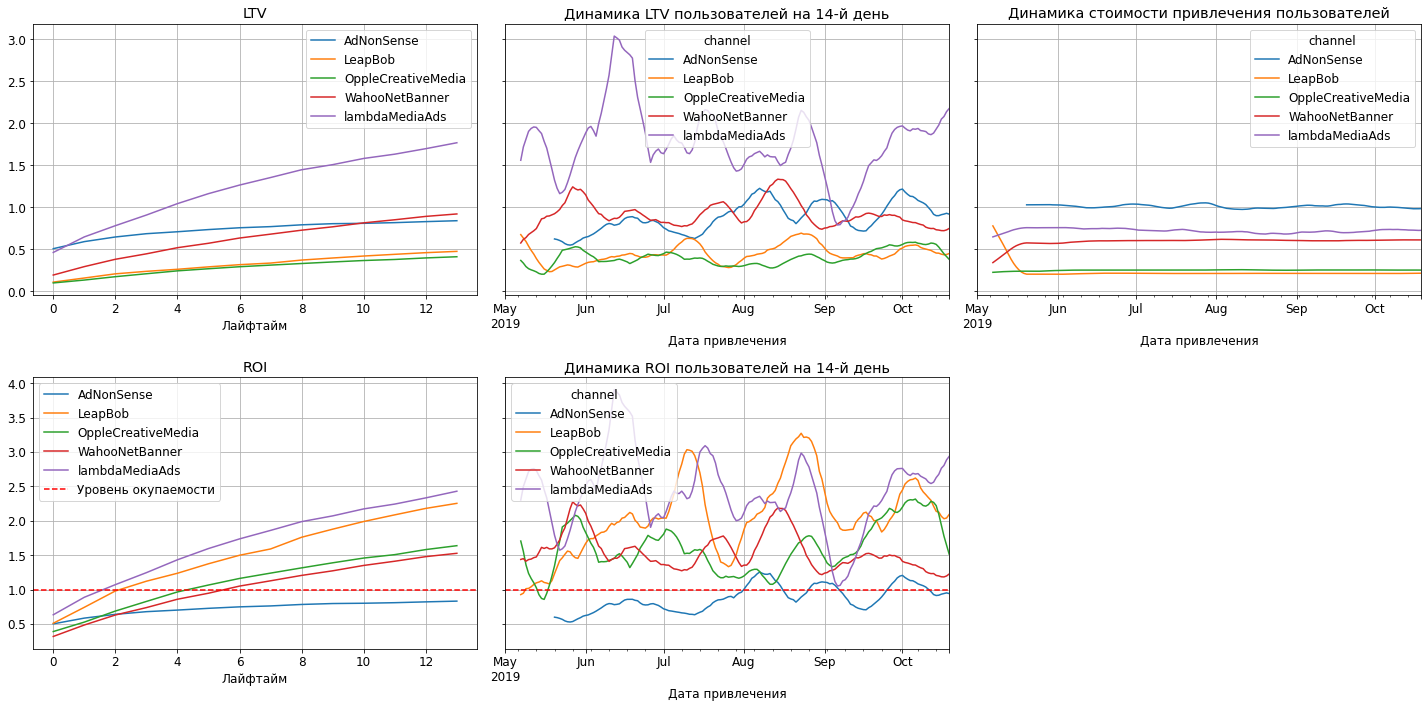

In [74]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    eu_profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)

#сгладим графики динамики ltv, roi и построим диаграммы
ltv_history_filtered = filter_data(ltv_history, 14)
roi_history_filtered = filter_data(roi_history, 14)
plot_ltv_roi(ltv_grouped, ltv_history_filtered, roi_grouped, roi_history_filtered, horizon_days) 

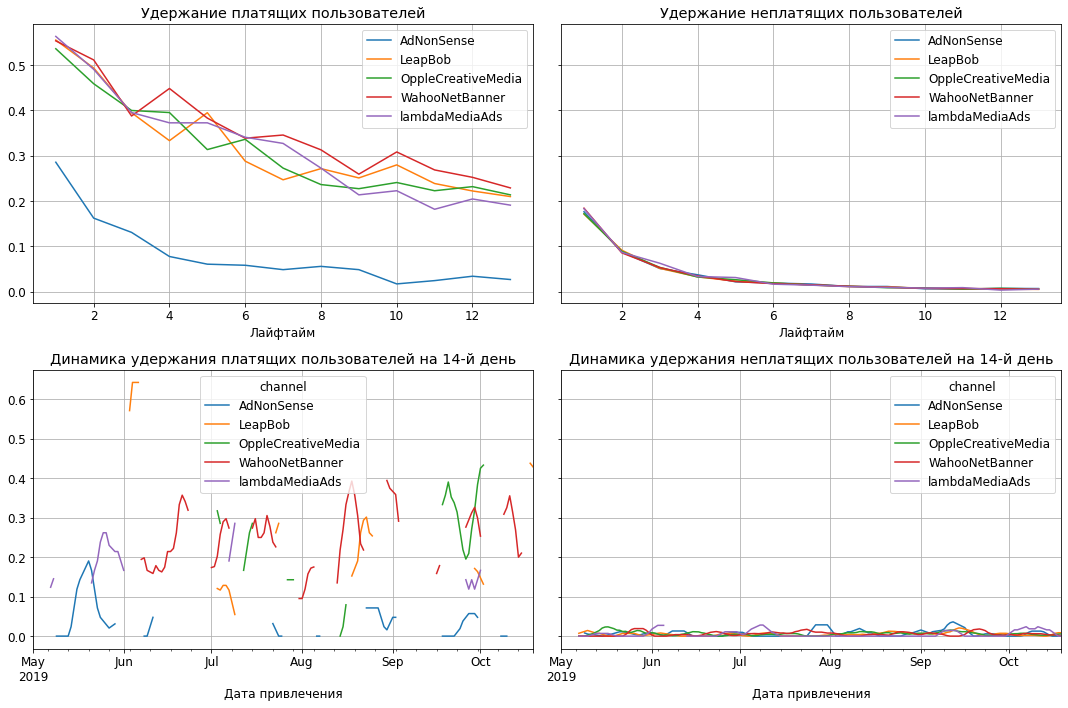

In [75]:
retention_raw, retention_grouped, retention_history = get_retention(
    eu_profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=dimensions)

#сгладим графики динамики удержания и построим диаграммы
retention_history_filtered = filter_data(retention_history, 3)
plot_retention(retention_grouped, retention_history_filtered, horizon_days)

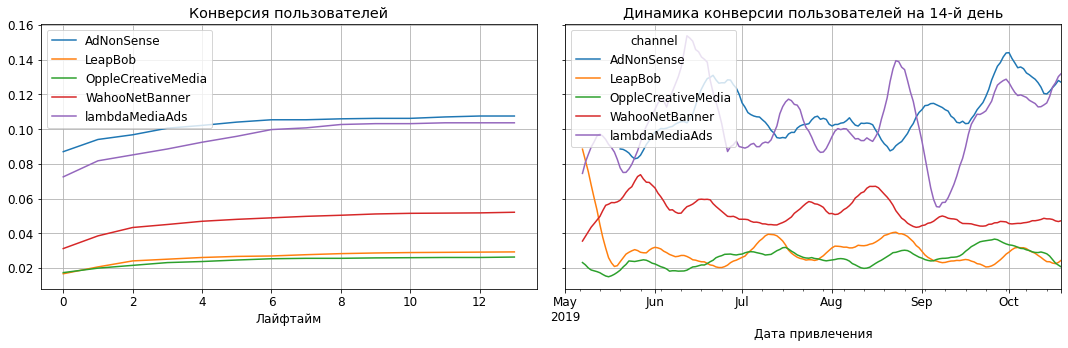

In [76]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    eu_profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=dimensions
)
#сгладим и построим график динамики конверсии
conversion_history_filtered = filter_data(conversion_history, 14)
plot_conversion(conversion_grouped, conversion_history_filtered, horizon_days)

AdNonSense - единственный канал в Европе, который не окупается. По нему самые высокие затраты на пользователя и худшее удержание. Видим хорошую динамику по lambdaMediaAds, 10.5% пользователей которой становятся покупателями и приносят компании наибольший доход. Из WahooNetBanner приходит больше пользователей, но всего 5.3% из них конвертируются в покупки. При неизменном CAC есть спад в динамике ROI и конверсии.

##### Вывод:

В разрезе устройств можно выделить пользователей PC - единственной когорты, превысившей уровень окупаемости в течение 2-х недель, траты на маркетинг по ним относительно невысоки и находятся на уровне \\$0.7-\\$0.9. У пользователей iPhone и Mac качество пользователей лучше, но стоимость их удержания выше и затраты на рекламу не окупаются.

Больше всего выручки приложение получает от пользователей из США, однако это единственная страна, затраты на привлечение пользователей которой не окупаются, тогда как затраты на маркетинг по остальным странам начинают окупаться уже на первой неделе жизни пользователей. 

Пользователи из большинства каналов не доживают до 14-го дня, при этом процент удержания достаточно высокий - около 20%. Самый стабильный по всем показателям канал - lambdaMediaAds - пользователи, пришедшие оттуда, приносят наибольший доход.

### Общий вывод

К концу 2-й недели уровень  ROI около 80%, т.е. реклама, направленная на привлечение пользователей в целом, не окупается. При этом LTV стабильно растет, то есть пользователи продолжают совершать покупки в приложении. Удержание платящих пользователей в среднем колеблется на уровне 10%. Наибольшее влияние на окупаемость оказывает рост рекламных расходов, ознакомимся с негативными факторами более детально.


**Причины плохой окупаемости:**

- США но это единственная страна, где затраты на привлечение пользователей не окупаются, а стоимость привлечения пользователей постоянно растет. Это следствие того, что удержание платящих пользователей гораздо ниже, чем у других когорт, и находится на уровне 10% против 15% для других стран. Вероятно, компания пыталась улучшить этот показатель повышением затрат на рекламу. Наибольшее влияние на эти факторы оказывают крупнейшие каналаы - TipTop и FaceBoom, по ним возврат инвестиций на уровне 70% и самые высокие траты на привлечение пользователей. 

- При хороших показателях качества пользователей, TipTop негативно влияет на окупаемость рекламы, поскольку затраты по этому каналу постоянно растут и достигают \\$3.6, когда затраты по другим каналам стабильно не превышают \\$1. Возможно, большая часть пользователей этого канала не является целевой аудиторией приложения Procrastinate Pro+. 

- FaceBoom в США и AdNonSense в Европе не окупаются, поскольку у пользователей, пришедших из этих каналов, несмотря на стабильные расходы и хорошую конверсию, худшее удержание.

- У пользователей iPhone, Mac и Android высокие показатели LTV и конверсии, но хуже они удерживаются, несмотря на более высокие затраты. Это может быть связано с неудобством интерфейса приложения для этих утройств, поскольку для пользователей PC мы видим лучшее удержание и окупаемость при низких затратах.

Поскольку американцы - самая многочисленная группа пользователей, стоит заметить, что в США высокая конкуренция, которая порождает высокую стоимость клика, соответственно растут и общие затраты на маркетинг. Более широкая география также увеличивает расходы на продвижение.

**Рекомендации:**

* Чтобы увеличить окупаемость по iPhone, Mac и Android можно внести изменения и провести А/Б-тесты для новых когорт, сравнить результаты. Также стоит изучить информацию о событиях, возможно, пользователи iPhone, Mac и Android на определенных этапах сталкиваются с техническими проблемами и покидают приложение.

* Американцы чаще других совершают целевые действия, их показатель конверсии с 6% в мае повышается до уровня 10% в июне (против 4-5% для европейцев) и приносят лучший доход. Крупнейший канал в США - TipTop - исключив его из выборки, можно увидеть, что стоимость привлечения пользователей устанавливается на уровне \\$0.7 и реклама начинает окупаться к середине второй недели. Будет полезно изучить ЦА, пришедшую из TipTop и настраивать рекламу, основываясь на этих данных. Также можно проанализировать регионы США и изменить маркетинговую стратегию для неээфективных территорий.

* Низкие показатели удержания пользователей из Великобритании, Германии и Франции могут быть связаны с их малым количеством. Исходя из хороших показателей окупаемости по ним, можно предположить, что в других европейских странах Procrastinate Pro+ также будет приносить доход.

* Необходимо принять меры по повышению удержания пользователей. Например, ввести челленджи для пришедших из AdNonSense в Европе или давать бонусы за взаимодействие с друзьями для пользователей из FaceBoom в США.

* В США положительную динамику ROI показывают каналы RocketSuperAds и MediaTornado, при этом пользователи, пришедшие из RocketSuperAds имеют хорошее удержание, а 8% из них становятся покупателями. В Европе стоит отметить хорошую динамику по lambdaMediaAds, 10.5% пользователей из этого канала становятся покупателями и приносят компании наибольший доход. Из WahooNetBanner приходит больше пользователей, но всего 5.3% из них конвертируются в покупки. При неизменном CAC падает ROI и конверсия. Возможно, стоит пересмотреть траты на высокобюджетные каналы в пользу RocketSuperAds, lambdaMediaAds и WahooNetBanner.